In [39]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV




%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from nb_modules import model as mod

In [2]:
building_df = pd.read_pickle('data/pickles/building_df.pkl')

In [3]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762106 entries, 0 to 762105
Data columns (total 55 columns):
building_id                               762106 non-null int64
district_id                               762106 non-null int64
vdcmun_id                                 762106 non-null int64
ward_id                                   762106 non-null int64
count_floors_pre_eq                       762106 non-null int64
age_building                              762106 non-null int64
plinth_area_sq_ft                         762106 non-null int64
height_ft_pre_eq                          762106 non-null int64
land_surface_condition                    762106 non-null object
foundation_type                           762106 non-null object
roof_type                                 762106 non-null object
ground_floor_type                         762106 non-null object
other_floor_type                          762106 non-null object
position                                  762106 non

In [4]:
building_df.columns

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'land_surface_condition_num', 'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num',
       'plan_configuration_num', 'target', 'has_geotechnical_risk',
       'has_geotechnical_risk_land_settlement',
  

3    60.31
1    21.79
2    17.90
Name: target, dtype: float64


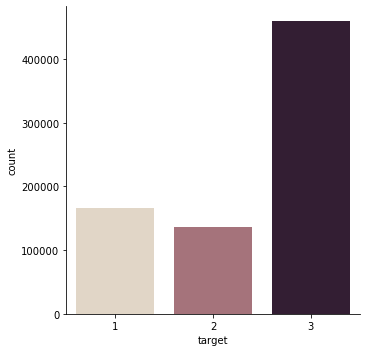

In [5]:
print(round(building_df['target'].value_counts(normalize=True)*100,2))
sns.catplot(x="target", kind="count", palette="ch:.25", data=building_df);

There is some level of class imbalance. 60% of the buildings in the dataset have severe or Grade 3 damage, while about 22% are buildings of Grade 1 with minor damages and 18% of buildings are of Grade 2 or major damages.

## Train Test Split for base line model

In [6]:
X_droplist = ['target','legal_ownership_status', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'plan_configuration', 'position']

X = building_df.drop(columns=X_droplist)
y = building_df['target']

#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (609684, 46) Target:  (609684,)
Test set - Features:  (152422, 46) Target:  (152422,)
3    0.603185
1    0.217613
2    0.179203
Name: target, dtype: float64
3    0.602656
1    0.219188
2    0.178157
Name: target, dtype: float64


## BASELINE MODEL
Multiclass Logistic Regression

In [7]:
lr1 = LogisticRegression(solver='lbfgs',multi_class='multinomial', random_state=100)

lr1.fit(X_train, y_train)

y_pred_test = lr1.predict(X_test)
y_pred_train = lr1.predict(X_train)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.6027
Train Accuracy score:  0.6032
Test F1 score:  0.4532
Train F1 score:  0.4539
Test Recall score:  0.6027
Train Recall score:  0.6032


In [8]:
mod_eval= {}
mod_eval['baseline_lr1']={'accuracy': .6027, 'f1':0.4532, 'recall': 0.6032}

## Feature Engineering

We have a lot of nominal variables that may best be turned to dummies. The corresponding *'num'* features will be added to the drop list to be removed from the main dataset to be used in modeling

In [9]:
# dummy_list=['dummy_1','dummy_2','dummy_3','dummy_4','dummy_5','dummy_6','dummy_7','dummy_8','dummy_9']
# nom_feats= ['ward_id', 'land_surface_condition', 'foundation_type',
#        'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
#        'plan_configuration','legal_ownership_status' ]

In [10]:
# for dummy, feat in zip(dummy_list, nom_feats):
#     print(dummy, feat)

In [11]:
# for dummy, feat in zip(dummy_list, nom_feats):
#     dummy = pd.DataFrame()
#     dummy = mod.dummify(building_df, feat)


In [12]:
dummy_1 = mod.dummify(building_df, 'ward_id')
dummy_2 = mod.dummify(building_df, 'land_surface_condition')
dummy_3 = mod.dummify(building_df, 'foundation_type')
dummy_4 = mod.dummify(building_df, 'roof_type')
dummy_5 = mod.dummify(building_df, 'ground_floor_type')
dummy_6 = mod.dummify(building_df, 'other_floor_type')
dummy_7 = mod.dummify(building_df, 'position')
dummy_8 = mod.dummify(building_df, 'plan_configuration')
dummy_9 = mod.dummify(building_df, 'legal_ownership_status')

Next, we drop all the dummified features, 

In [13]:
drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk']

In [14]:
building_df.drop(columns= drop_list, inplace=True)

In [15]:
df_list= [building_df, dummy_1 , dummy_2 , dummy_3 , dummy_4 , dummy_5 , dummy_6 , dummy_7 , dummy_8 , dummy_9]
for df in df_list:
    print(df.shape)


(762106, 36)
(762106, 18)
(762106, 2)
(762106, 4)
(762106, 2)
(762106, 4)
(762106, 3)
(762106, 3)
(762106, 9)
(762106, 3)


In [16]:
X = pd.concat(df_list, axis=1)

In [17]:
y = X['target']
X.drop(['target'], axis=1, inplace=True)

In [18]:
print(X.shape)
print(y.shape)

(762106, 83)
(762106,)


### Polynomial Features

In [19]:
# #Instantiating polynomial features object
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # applying polynomial feature object to data
# poly_data = poly.fit_transform(X)

# #assigning feature names from main dataframe
# poly_columns = poly.get_feature_names(X.columns)

# #converting array to dataframe
# df_poly = pd.DataFrame(poly_data, columns = poly_columns)

In [20]:
# df_poly.shape

(762106, 3569)

In [21]:
# np.sqrt(762106)

872.9868269338318

## Train Test Split - dataset after polynomial features

In [22]:
# #performing train-test split on main dataframe
# X_train, X_test, y_train, y_test = train_test_split(df_poly, y, random_state=100, test_size=0.3)

# #checking the shape of the training set and test set
# print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
# print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
# print('============================================ ')
# print(y_train.value_counts(normalize = True))
# print(y_test.value_counts(normalize = True))

## Feature Selection using PCA

**PCA Step-by-step**
* It is important to center and standardize your data. PCA lives off of correlation and covariance of your data, and using wildly different scales could lead to inflated weights for the linear combination. Let's call this centered and standardized matrix Z.
* Calculate a covariance matrix of p x p where p responds to number of predictors.
* Calculate the eigenvectors and eigenvalues of the covariance matrix.
* Arrange the eigenvalues from largest to smallest. You should obtain p eigenvalues which correspond to number of components.
* Choose the amount of components you want to include based on number of variance explained.

In [ ]:
# # preprocess the data 
# from sklearn.preprocessing import StandardScaler

# x = df_poly.loc.values
# # Separating out the target
# #y = df.loc[:,['mpg']].values

## Train Test Split

In [28]:
#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.4)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (457263, 83) Target:  (457263,)
Test set - Features:  (304843, 83) Target:  (304843,)
3    0.603718
1    0.217566
2    0.178716
Name: target, dtype: float64
3    0.60212
1    0.21847
2    0.17941
Name: target, dtype: float64


## Class Imbalance
Going forward to tackle the class imbalance problem in the data, we will use a class weight dictionary to defince the class weight to be used in the models

In [33]:
round(y.value_counts(normalize=True)*100,2)

3    60.31
1    21.79
2    17.90
Name: target, dtype: float64

In [37]:
cw= {3: 20, 1: 35, 2: 45}

# Models

**Unweighted Multiclass Logistic Regression Classification**

In [35]:
lr2 = LogisticRegression(solver='lbfgs',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=1e4,
                                verbose=1, n_jobs=-1)

lr2.fit(X_train, y_train) #fit logreg model on n_features = 50

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test)
y_pred_train = lr2.predict(X_train)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.0s finished


Test Accuracy score:  0.6021
Train Accuracy score:  0.6037
Test F1 score:  0.4526
Train F1 score:  0.4545
Test Recall score:  0.6021
Train Recall score:  0.6037


**Weighted Multiclass Logistic Regression Classification**

In [38]:
lr3 = LogisticRegression(class_weight=cw, solver='lbfgs',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=1e4,
                                verbose=1, n_jobs=-1 )

lr3.fit(X_train, y_train) 

# class predictions (not predicted probabilities)
y_pred_test = lr3.predict(X_test)
y_pred_train = lr3.predict(X_train)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.5s finished


Test Accuracy score:  0.6021
Train Accuracy score:  0.6037
Test F1 score:  0.4526
Train F1 score:  0.4545
Test Recall score:  0.6021
Train Recall score:  0.6037


### KNN ---- scaling with MinMaxScaler

In [41]:
scaler = MinMaxScaler()  
scaler.fit(X_train)

X_train_scale1 = scaler.transform(X_train)  
X_test_scale1 = scaler.transform(X_test)


In [43]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)

knn.fit(X_train_scale1, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred_scale1 =knn.predict(X_test_scale1)

In [42]:
print('f1score - all scaled:' + str(round(metrics.f1_score(y_test, y_pred_scale1, average='weighted'),4))

KeyboardInterrupt: 